# load each dataset in a grid 

In [1]:
import os
import glob

from inspect_ai.log import EvalLog, read_eval_log


fill_ratios = [0.3, 0.5, 0.7, 0.9]
related_ratios = [0.3, 0.5, 0.7, 0.9]
logs: list[list[EvalLog]] = [[] for _ in fill_ratios]

log_dir = "../logs/inital_sweep"

def get_eval_file(folder_path):
    """Get the single .eval file from a folder, raise error if not exactly 1."""
    eval_files = glob.glob(os.path.join(folder_path, "*.eval"))
    
    if len(eval_files) == 0:
        raise FileNotFoundError(f"No .eval file found in {folder_path}")
    elif len(eval_files) > 1:
        raise ValueError(f"Multiple .eval files found in {folder_path}: {eval_files}")
    
    return eval_files[0]

for (fill_index, fill) in enumerate(fill_ratios):
    for related in related_ratios:
        folder = os.path.join(log_dir, "fill_ratio_" + str(fill), "related_ratio_" + str(related))
        eval_file = get_eval_file(folder)
        log = read_eval_log(eval_file, resolve_attachments=False, header_only=True)
        print(f"loaded log file: {eval_file}")
        logs[fill_index].append(log)



loaded log file: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.5/2025-07-29T11-43-39+01-00_directors-task_2ego7FcpKQL72HE5ZWdXeH.eval
loaded log file: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.7/2025-07-29T14-14-19+01-00_directors-task_HydeRoCyMHqX2jghZhqxfe.eval
loaded log file: ../

## now calculate and graph the accuracy for control

In [2]:
import gc


control_samples = [[[] for _ in related_ratios] for _ in fill_ratios]
control_accuracy = [[] for _ in fill_ratios]

for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"processing log: {log.location}")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        assert temp_log.samples is not None
        num_correct = 0
        num_samples = 0
        for sample in temp_log.samples:
            if sample.metadata["sample_type"] =="control":
                #control_samples[fill_index][related_index].append(sample)
                num_samples += 1
                assert sample.score is not None
                if sample.score.value == "C":
                    num_correct += 1

        control_accuracy[fill_index].append(num_correct / num_samples)
        del temp_log
        gc.collect()

        

processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval


The 'score' field is deprecated. Access sample scores through 'scores' instead.


processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.5/2025-07-29T11-43-39+01-00_directors-task_2ego7FcpKQL72HE5ZWdXeH.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.7/2025-07-29T14-14-19+01-00_directors-task_HydeRoCyMHqX2jghZhqxfe.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.9/2025-07-29T15-44-25+01-00_directors-task_HvU5HRYiVoGmZEaaXPxhsN.eval
processing log: ../logs/ini

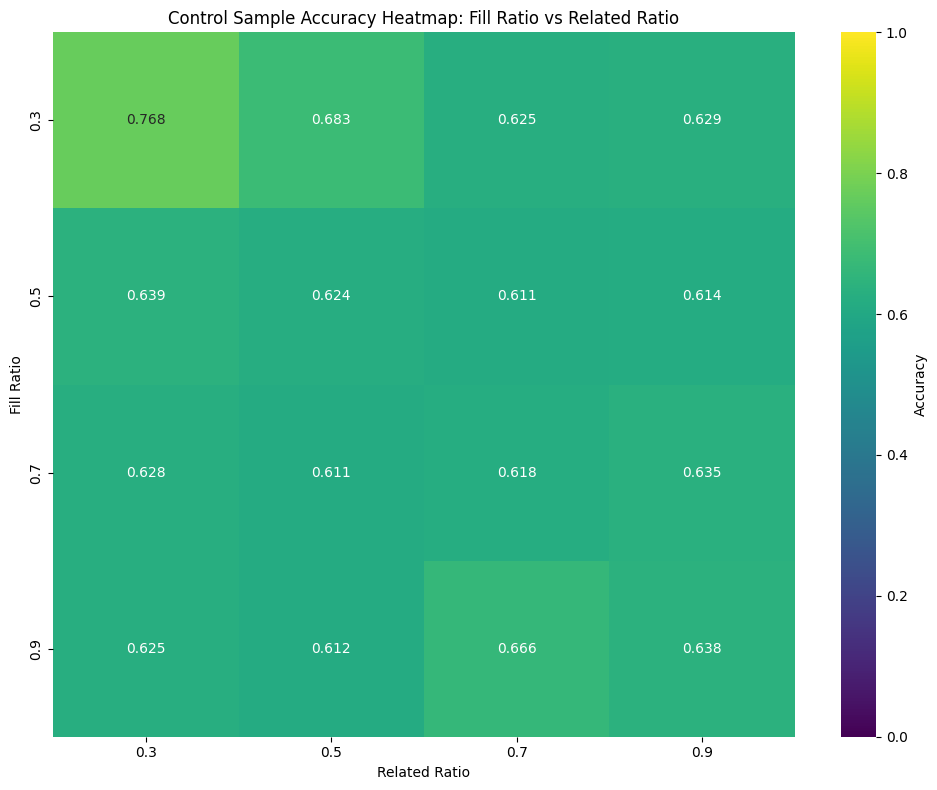

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert control_accuracy to numpy array for heatmap
accuracy_matrix = np.array(control_accuracy)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix, 
            vmin=0,
            vmax=1,
            xticklabels=[f"{r:.1f}" for r in related_ratios],
            yticklabels=[f"{f:.1f}" for f in fill_ratios],
            annot=True, 
            fmt='.3f',
            cmap='viridis',
            cbar_kws={'label': 'Accuracy'})

plt.xlabel('Related Ratio')
plt.ylabel('Fill Ratio')
plt.title('Control Sample Accuracy Heatmap: Fill Ratio vs Related Ratio')
plt.tight_layout()
plt.show()

## now calculate the accuracy for test samples

In [4]:
test_samples = [[[] for _ in related_ratios] for _ in fill_ratios]
test_accuracy = [[] for _ in fill_ratios]

for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"processing log: {log.location}")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        assert temp_log.samples is not None
        num_correct = 0
        num_samples = 0
        for sample in temp_log.samples:
            if sample.metadata["sample_type"] =="test":
                #test_samples[fill_index][related_index].append(sample)
                num_samples += 1
                assert sample.score is not None
                if sample.score.value == "C":
                    num_correct += 1

        test_accuracy[fill_index].append(num_correct / num_samples)
        del temp_log
        gc.collect()

processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.5/2025-07-29T11-43-39+01-00_directors-task_2ego7FcpKQL72HE5ZWdXeH.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.7/2025-07-29T14-14-19+01-00_directors-task_HydeRoCyMHqX2jghZhqxfe.eval
processing log: ../logs/ini

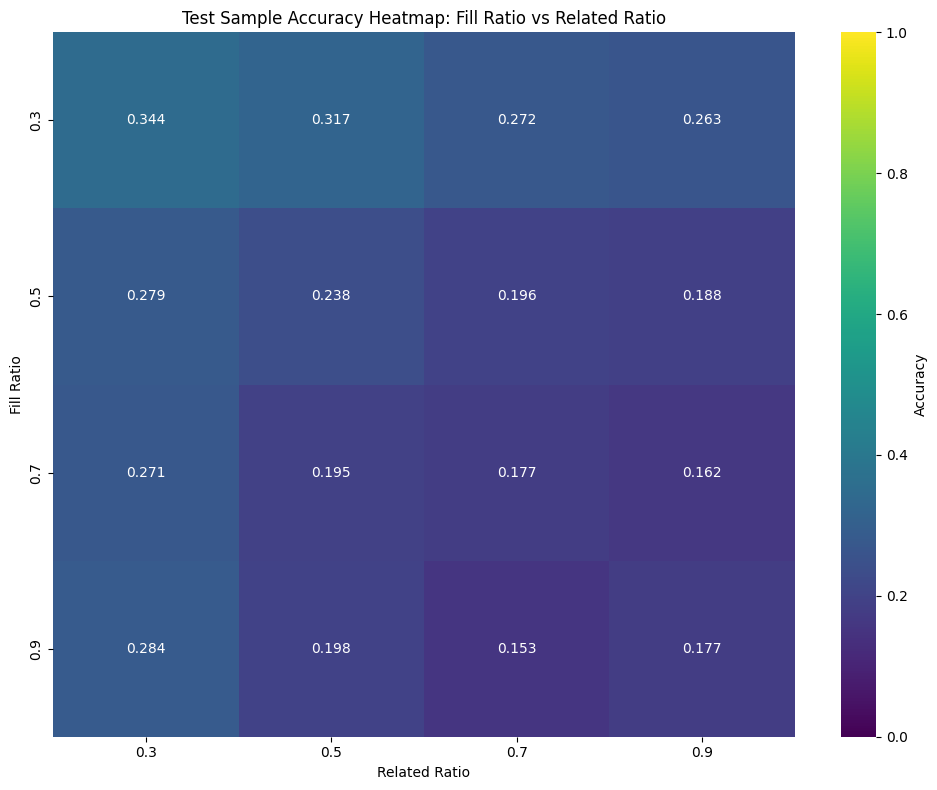

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert control_accuracy to numpy array for heatmap
accuracy_matrix = np.array(test_accuracy)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix, 
            vmin=0,
            vmax=1,
            xticklabels=[f"{r:.1f}" for r in related_ratios],
            yticklabels=[f"{f:.1f}" for f in fill_ratios],
            annot=True, 
            fmt='.3f',
            cmap='viridis',
            cbar_kws={'label': 'Accuracy'})

plt.xlabel('Related Ratio')
plt.ylabel('Fill Ratio')
plt.title('Test Sample Accuracy Heatmap: Fill Ratio vs Related Ratio')
plt.tight_layout()
plt.show()

## Accuracy Difference: Control - Test

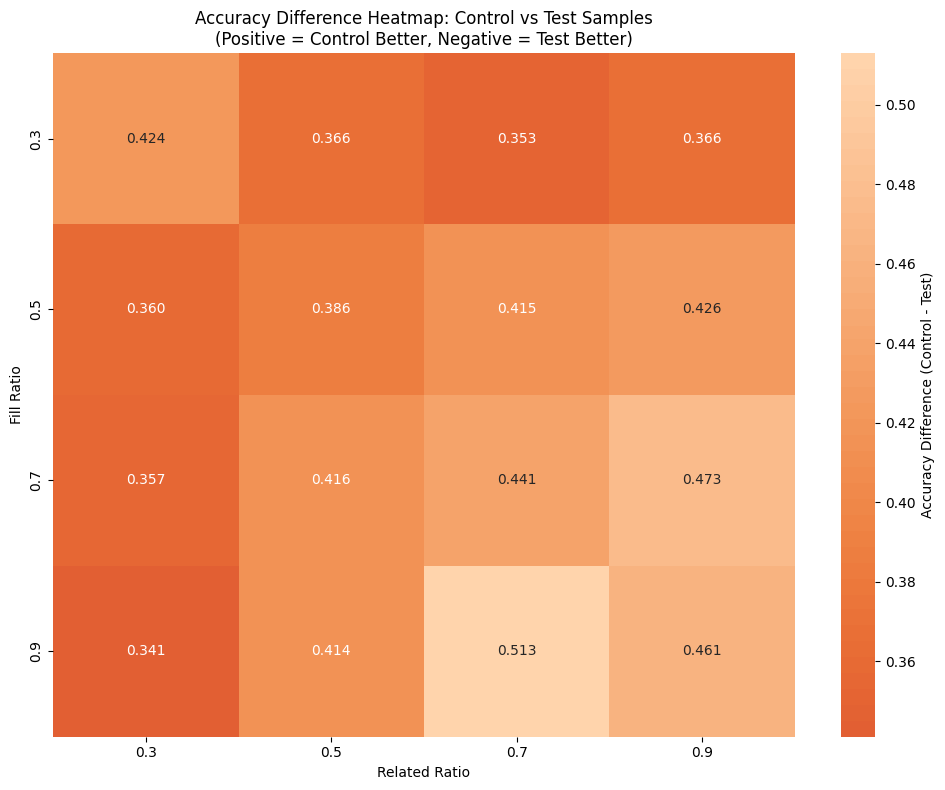

In [7]:
# Calculate the difference: control accuracy - test accuracy
control_matrix = np.array(control_accuracy)
test_matrix = np.array(test_accuracy)
difference_matrix = control_matrix - test_matrix

# Create the difference heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(difference_matrix, 
            xticklabels=[f"{r:.1f}" for r in related_ratios],
            yticklabels=[f"{f:.1f}" for f in fill_ratios],
            annot=True, 
            fmt='.3f',
            #cmap='RdBu_r',  # Red-Blue colormap where red=positive (control better), blue=negative (test better)
            center=0,       # Center the colormap at 0
            cbar_kws={'label': 'Accuracy Difference (Control - Test)'})

plt.xlabel('Related Ratio')
plt.ylabel('Fill Ratio')
plt.title('Accuracy Difference Heatmap: Control vs Test Samples\n(Positive = Control Better, Negative = Test Better)')
plt.tight_layout()
plt.show()

## now look at the effect of reversal

In [15]:
# Calculate accuracy by selection_rule split by is_reversed
from collections import defaultdict

# Structure: {selection_rule: {'reversed': [accuracies], 'not_reversed': [accuracies]}}
selection_rule_accuracy = defaultdict(lambda: {'reversed': [], 'not_reversed': []})

# Collect all unique selection rules first
all_selection_rules = set(["none", "size_related", "spatial_same_perspective", "spatial_different_perspective"])

print(f"Found selection rules: {sorted(all_selection_rules)}")

# Second pass: calculate accuracies by selection_rule and is_reversed
for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"processing log: {log.location}")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        
        # Track counts for each selection_rule and reversal state
        rule_counts = defaultdict(lambda: {'reversed': {'correct': 0, 'total': 0}, 
                                         'not_reversed': {'correct': 0, 'total': 0}})
        assert temp_log.samples is not None
        for sample in temp_log.samples:
            if "selection_rule_type" in sample.metadata and "is_reversed" in sample.metadata:
                rule = sample.metadata["selection_rule_type"]
                is_reversed = sample.metadata["is_reversed"]
                
                # Determine category
                category = 'reversed' if is_reversed else 'not_reversed'
                
                # Count total and correct
                rule_counts[rule][category]['total'] += 1
                if sample.score.value == "C":
                    rule_counts[rule][category]['correct'] += 1
        
        # Calculate accuracies for this log file
        for rule in rule_counts:
            for category in ['reversed', 'not_reversed']:
                if rule_counts[rule][category]['total'] > 0:
                    accuracy = rule_counts[rule][category]['correct'] / rule_counts[rule][category]['total']
                    selection_rule_accuracy[rule][category].append(accuracy)
                else:
                    # No samples for this rule/category combination in this file
                    selection_rule_accuracy[rule][category].append(None)
        
        del temp_log
        gc.collect()

# Print summary statistics
print("\nSummary by selection rule and reversal:")
for rule in sorted(selection_rule_accuracy.keys()):
    print(f"\n{rule}:")
    
    # Filter out None values for calculations
    reversed_accs = [acc for acc in selection_rule_accuracy[rule]['reversed'] if acc is not None]
    not_reversed_accs = [acc for acc in selection_rule_accuracy[rule]['not_reversed'] if acc is not None]
    
    if reversed_accs:
        print(f"  Reversed: mean={np.mean(reversed_accs):.3f}, std={np.std(reversed_accs):.3f}, n={len(reversed_accs)} files")
    else:
        print(f"  Reversed: no data")
        
    if not_reversed_accs:
        print(f"  Not reversed: mean={np.mean(not_reversed_accs):.3f}, std={np.std(not_reversed_accs):.3f}, n={len(not_reversed_accs)} files")
    else:
        print(f"  Not reversed: no data")

Found selection rules: ['none', 'size_related', 'spatial_different_perspective', 'spatial_same_perspective']
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.5/2025-07-29T11-43-39+01-00_directors-task_2ego7FcpKQL72HE5ZWdXeH.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/relat

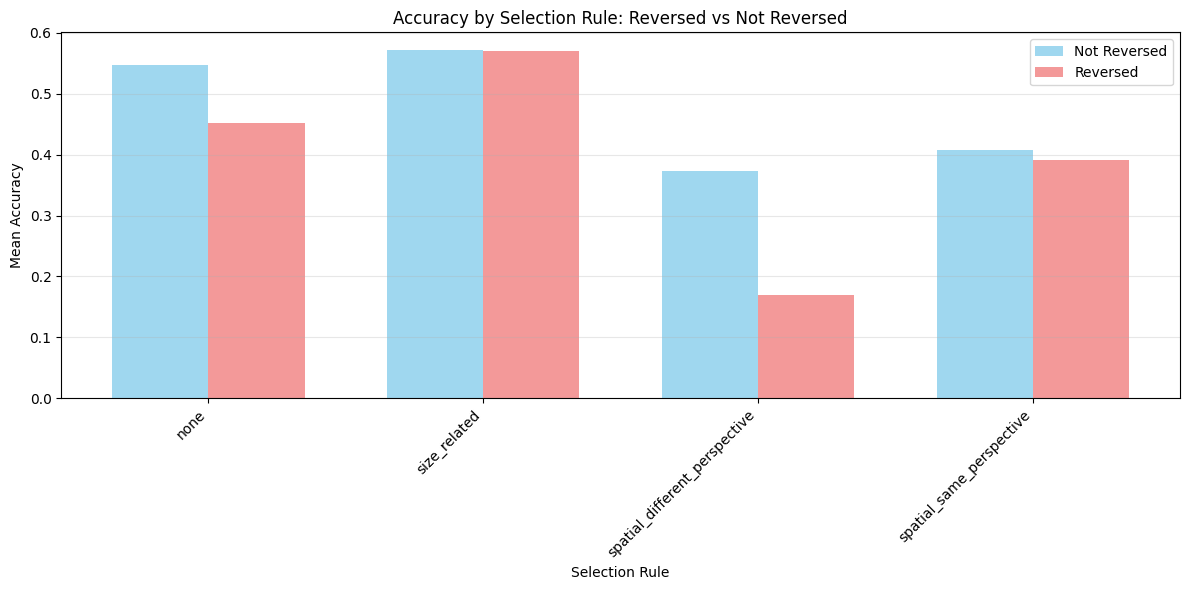

In [16]:
# Visualize selection rule accuracy by reversal - grouped bar chart
plt.figure(figsize=(12, 6))

# Prepare data for plotting
rules = sorted(selection_rule_accuracy.keys())
reversed_means = []
not_reversed_means = []

for rule in rules:
    # Filter out None values and calculate means
    reversed_accs = [acc for acc in selection_rule_accuracy[rule]['reversed'] if acc is not None]
    not_reversed_accs = [acc for acc in selection_rule_accuracy[rule]['not_reversed'] if acc is not None]
    
    reversed_means.append(np.mean(reversed_accs) if reversed_accs else 0)
    not_reversed_means.append(np.mean(not_reversed_accs) if not_reversed_accs else 0)

# Create grouped bar chart
x = np.arange(len(rules))
width = 0.35

plt.bar(x - width/2, not_reversed_means, width, label='Not Reversed', alpha=0.8, color='skyblue')
plt.bar(x + width/2, reversed_means, width, label='Reversed', alpha=0.8, color='lightcoral')

plt.xlabel('Selection Rule')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Selection Rule: Reversed vs Not Reversed')
plt.xticks(x, rules, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.5/2025-07-29T11-43-39+01-00_directors-task_2ego7FcpKQL72HE5ZWdXeH.eval
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.7/2025-07-29T14-14-19+01-00_directors-task_HydeRoCyMHqX2jghZhqxfe.eval
processing log: ../logs/ini

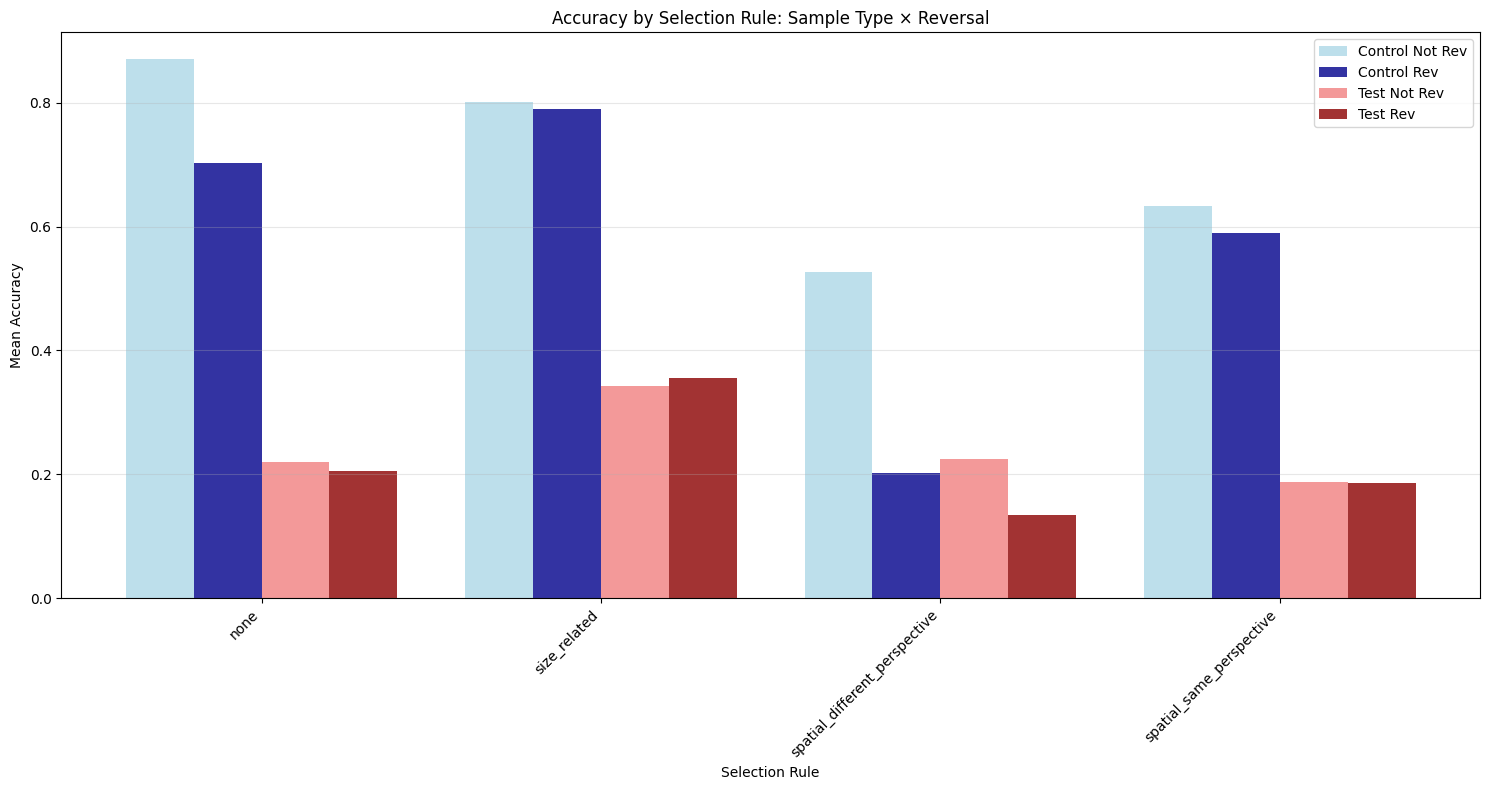


Detailed Summary:

none:
  Control Not Rev: mean=0.870, std=0.040, n=16
  Control Rev: mean=0.702, std=0.064, n=16
  Test Not Rev: mean=0.220, std=0.096, n=16
  Test Rev: mean=0.205, std=0.081, n=16

size_related:
  Control Not Rev: mean=0.800, std=0.042, n=16
  Control Rev: mean=0.789, std=0.029, n=16
  Test Not Rev: mean=0.342, std=0.059, n=16
  Test Rev: mean=0.355, std=0.047, n=16

spatial_different_perspective:
  Control Not Rev: mean=0.527, std=0.123, n=16
  Control Rev: mean=0.203, std=0.141, n=16
  Test Not Rev: mean=0.225, std=0.053, n=16
  Test Rev: mean=0.134, std=0.093, n=16

spatial_same_perspective:
  Control Not Rev: mean=0.634, std=0.069, n=16
  Control Rev: mean=0.590, std=0.061, n=16
  Test Not Rev: mean=0.188, std=0.056, n=16
  Test Rev: mean=0.186, std=0.061, n=16


In [21]:
# Calculate accuracy by selection_rule split by BOTH sample_type and is_reversed
from collections import defaultdict

# Structure: {selection_rule: {'control_not_reversed': [accuracies], 'control_reversed': [accuracies], 
#                              'test_not_reversed': [accuracies], 'test_reversed': [accuracies]}}
detailed_accuracy = defaultdict(lambda: {
    'control_not_reversed': [], 'control_reversed': [],
    'test_not_reversed': [], 'test_reversed': []
})

all_selection_rules = ["none", "size_related", "spatial_same_perspective", "spatial_different_perspective"]

# Calculate accuracies by selection_rule, sample_type, and is_reversed
for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"processing log: {log.location}")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        
        # Track counts for each combination
        rule_counts = defaultdict(lambda: {
            'control_not_reversed': {'correct': 0, 'total': 0},
            'control_reversed': {'correct': 0, 'total': 0},
            'test_not_reversed': {'correct': 0, 'total': 0},
            'test_reversed': {'correct': 0, 'total': 0}
        })
        
        assert temp_log.samples is not None
        for sample in temp_log.samples:
            if ("selection_rule_type" in sample.metadata and 
                "is_reversed" in sample.metadata and 
                "sample_type" in sample.metadata):
                
                rule = sample.metadata["selection_rule_type"]
                is_reversed = sample.metadata["is_reversed"]
                sample_type = sample.metadata["sample_type"]
                
                # Create category key
                category = f"{sample_type}_{'reversed' if is_reversed else 'not_reversed'}"
                
                # Count total and correct
                rule_counts[rule][category]['total'] += 1
                if sample.score.value == "C":
                    rule_counts[rule][category]['correct'] += 1
        
        # Calculate accuracies for this log file
        for rule in rule_counts:
            for category in ['control_not_reversed', 'control_reversed', 'test_not_reversed', 'test_reversed']:
                if rule_counts[rule][category]['total'] > 0:
                    accuracy = rule_counts[rule][category]['correct'] / rule_counts[rule][category]['total']
                    detailed_accuracy[rule][category].append(accuracy)
                else:
                    detailed_accuracy[rule][category].append(None)
        
        del temp_log
        gc.collect()

# Create 4-bar grouped chart
plt.figure(figsize=(15, 8))

rules = sorted(detailed_accuracy.keys())
categories = ['control_not_reversed', 'control_reversed', 'test_not_reversed', 'test_reversed']
colors = ['lightblue', 'darkblue', 'lightcoral', 'darkred']
labels = ['Control Not Rev', 'Control Rev', 'Test Not Rev', 'Test Rev']

# Calculate means for each category
means_by_category = {cat: [] for cat in categories}
for rule in rules:
    for cat in categories:
        values = [acc for acc in detailed_accuracy[rule][cat] if acc is not None]
        means_by_category[cat].append(np.mean(values) if values else 0)

# Create grouped bars
x = np.arange(len(rules))
width = 0.2

for i, (cat, color, label) in enumerate(zip(categories, colors, labels)):
    plt.bar(x + i * width - 1.5*width, means_by_category[cat], width, 
           label=label, color=color, alpha=0.8)

plt.xlabel('Selection Rule')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Selection Rule: Sample Type × Reversal')
plt.xticks(x, rules, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print summary
print("\nDetailed Summary:")
for rule in sorted(detailed_accuracy.keys()):
    print(f"\n{rule}:")
    for cat, label in zip(categories, labels):
        values = [acc for acc in detailed_accuracy[rule][cat] if acc is not None]
        if values:
            print(f"  {label}: mean={np.mean(values):.3f}, std={np.std(values):.3f}, n={len(values)}")
        else:
            print(f"  {label}: no data")

processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval (fill_ratio=0.3)
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval (fill_ratio=0.3)
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval (fill_ratio=0.3)
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval (fill_ratio=0.3)
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval (fill_ratio=0.5)
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.5/2025-07-29T11-43-39+01-00_directors-task_2ego7FcpKQL72HE5ZWdXeH.eval (fill_ratio=0.5)
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_rati

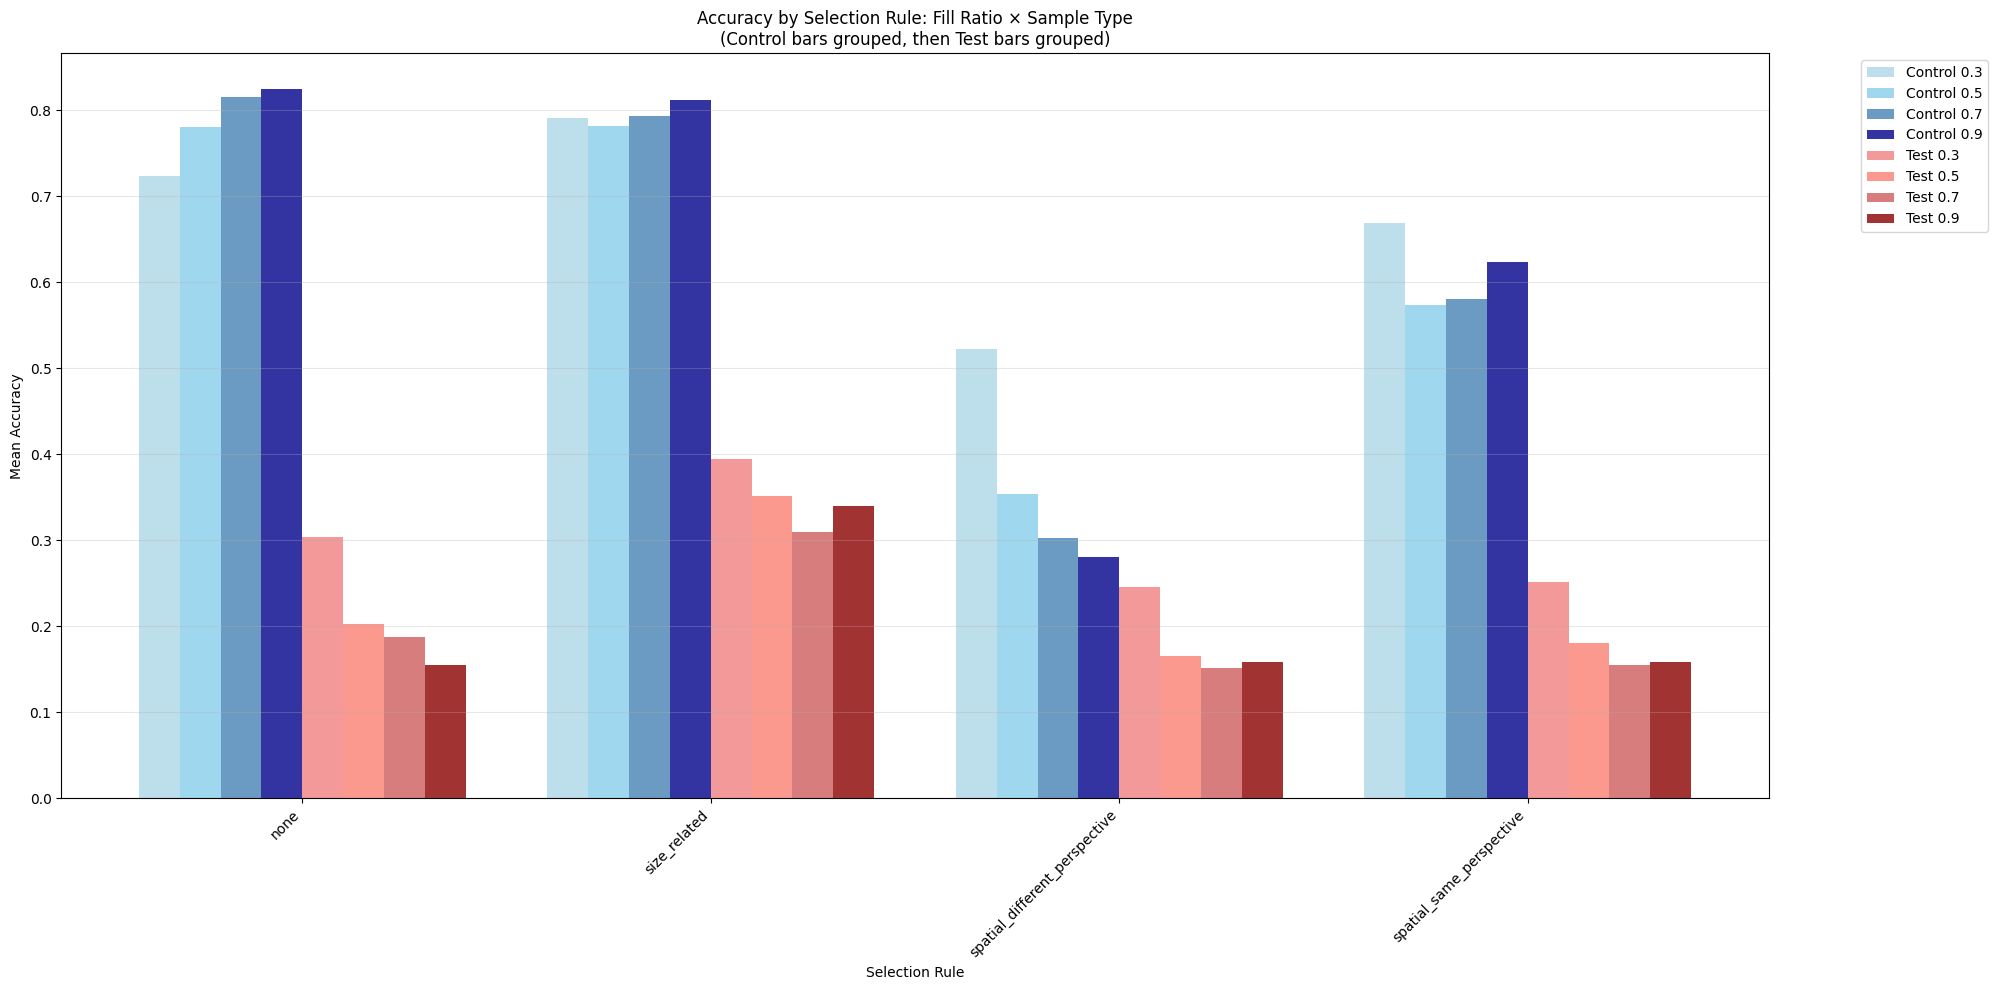


Summary by Selection Rule, Fill Ratio, and Sample Type:

none:
  Control 0.3: mean=0.723, std=0.019, n=4
  Control 0.5: mean=0.780, std=0.014, n=4
  Control 0.7: mean=0.815, std=0.030, n=4
  Control 0.9: mean=0.825, std=0.032, n=4
  Test 0.3: mean=0.304, std=0.080, n=4
  Test 0.5: mean=0.203, std=0.054, n=4
  Test 0.7: mean=0.188, std=0.055, n=4
  Test 0.9: mean=0.155, std=0.061, n=4

size_related:
  Control 0.3: mean=0.791, std=0.029, n=4
  Control 0.5: mean=0.781, std=0.015, n=4
  Control 0.7: mean=0.793, std=0.035, n=4
  Control 0.9: mean=0.812, std=0.029, n=4
  Test 0.3: mean=0.394, std=0.002, n=4
  Test 0.5: mean=0.352, std=0.035, n=4
  Test 0.7: mean=0.310, std=0.050, n=4
  Test 0.9: mean=0.340, std=0.046, n=4

spatial_different_perspective:
  Control 0.3: mean=0.522, std=0.154, n=4
  Control 0.5: mean=0.354, std=0.025, n=4
  Control 0.7: mean=0.303, std=0.042, n=4
  Control 0.9: mean=0.280, std=0.033, n=4
  Test 0.3: mean=0.246, std=0.063, n=4
  Test 0.5: mean=0.166, std=0.038,

In [24]:
# Calculate accuracy by selection_rule split by fill_ratio AND sample_type
from collections import defaultdict

# Structure: {selection_rule: {'control_fill_0.3': [accuracies], 'test_fill_0.3': [accuracies], etc}}
fill_sample_accuracy = defaultdict(lambda: {
    'control_fill_0.3': [], 'test_fill_0.3': [],
    'control_fill_0.5': [], 'test_fill_0.5': [],
    'control_fill_0.7': [], 'test_fill_0.7': [],
    'control_fill_0.9': [], 'test_fill_0.9': []
})

all_selection_rules = ["none", "size_related", "spatial_same_perspective", "spatial_different_perspective"]

# Calculate accuracies by selection_rule, fill_ratio, and sample_type
for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"processing log: {log.location} (fill_ratio={fill})")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        
        # Track counts for each combination
        rule_counts = defaultdict(lambda: {
            'control': {'correct': 0, 'total': 0},
            'test': {'correct': 0, 'total': 0}
        })
        
        assert temp_log.samples is not None
        for sample in temp_log.samples:
            if ("selection_rule_type" in sample.metadata and 
                "sample_type" in sample.metadata):
                
                rule = sample.metadata["selection_rule_type"]
                sample_type = sample.metadata["sample_type"]
                
                # Count total and correct for this rule and sample type
                rule_counts[rule][sample_type]['total'] += 1
                if sample.score.value == "C":
                    rule_counts[rule][sample_type]['correct'] += 1
        
        # Calculate accuracies for each rule/sample_type combination at this fill_ratio
        for rule in rule_counts:
            for sample_type in ['control', 'test']:
                category_key = f"{sample_type}_fill_{fill}"
                if rule_counts[rule][sample_type]['total'] > 0:
                    accuracy = rule_counts[rule][sample_type]['correct'] / rule_counts[rule][sample_type]['total']
                    fill_sample_accuracy[rule][category_key].append(accuracy)
                else:
                    fill_sample_accuracy[rule][category_key].append(None)
        
        del temp_log
        gc.collect()

# Create 8-bar grouped chart - control bars first, then test bars
plt.figure(figsize=(20, 10))

rules = sorted(fill_sample_accuracy.keys())

# Reorganize: all control bars together, then all test bars together
categories = [
    'control_fill_0.3', 'control_fill_0.5', 'control_fill_0.7', 'control_fill_0.9',
    'test_fill_0.3', 'test_fill_0.5', 'test_fill_0.7', 'test_fill_0.9'
]

# Colors: 4 shades for control (blues), 4 shades for test (reds)
colors = [
    'lightblue', 'skyblue', 'steelblue', 'darkblue',        # Control bars
    'lightcoral', 'salmon', 'indianred', 'darkred'         # Test bars
]

labels = [
    'Control 0.3', 'Control 0.5', 'Control 0.7', 'Control 0.9',
    'Test 0.3', 'Test 0.5', 'Test 0.7', 'Test 0.9'
]

# Calculate means for each category
means_by_category = {cat: [] for cat in categories}
for rule in rules:
    for cat in categories:
        values = [acc for acc in fill_sample_accuracy[rule][cat] if acc is not None]
        means_by_category[cat].append(np.mean(values) if values else 0)

# Create grouped bars
x = np.arange(len(rules))
width = 0.1

for i, (cat, color, label) in enumerate(zip(categories, colors, labels)):
    plt.bar(x + i * width - 3.5*width, means_by_category[cat], width, 
           label=label, color=color, alpha=0.8)

plt.xlabel('Selection Rule')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Selection Rule: Fill Ratio × Sample Type\n(Control bars grouped, then Test bars grouped)')
plt.xticks(x, rules, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print summary
print("\nSummary by Selection Rule, Fill Ratio, and Sample Type:")
for rule in sorted(fill_sample_accuracy.keys()):
    print(f"\n{rule}:")
    for cat, label in zip(categories, labels):
        values = [acc for acc in fill_sample_accuracy[rule][cat] if acc is not None]
        if values:
            print(f"  {label}: mean={np.mean(values):.3f}, std={np.std(values):.3f}, n={len(values)}")
        else:
            print(f"  {label}: no data")

processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.3/2025-07-18T18-08-19+01-00_directors-task_jRcfdm95D5GxWFrHhJuMGt.eval (related_ratio=0.3)
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.5/2025-07-22T13-54-02+01-00_directors-task_bTnfRxmVTeCn87mePcThbT.eval (related_ratio=0.5)
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.7/2025-07-23T13-47-30+01-00_directors-task_K3DSsovPoQfdRFh9s4PFzN.eval (related_ratio=0.7)
processing log: ../logs/inital_sweep/fill_ratio_0.3/related_ratio_0.9/2025-07-24T14-27-52+01-00_directors-task_bLmykhUz2QRmewQP6RGVYM.eval (related_ratio=0.9)
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.3/2025-07-18T15-47-48+01-00_directors-task_KkqPyaQHdTJq2VxZtn4UPo.eval (related_ratio=0.3)
processing log: ../logs/inital_sweep/fill_ratio_0.5/related_ratio_0.5/2025-07-29T11-43-39+01-00_directors-task_2ego7FcpKQL72HE5ZWdXeH.eval (related_ratio=0.5)
processing log: ../logs/inital_sweep/fill_rati

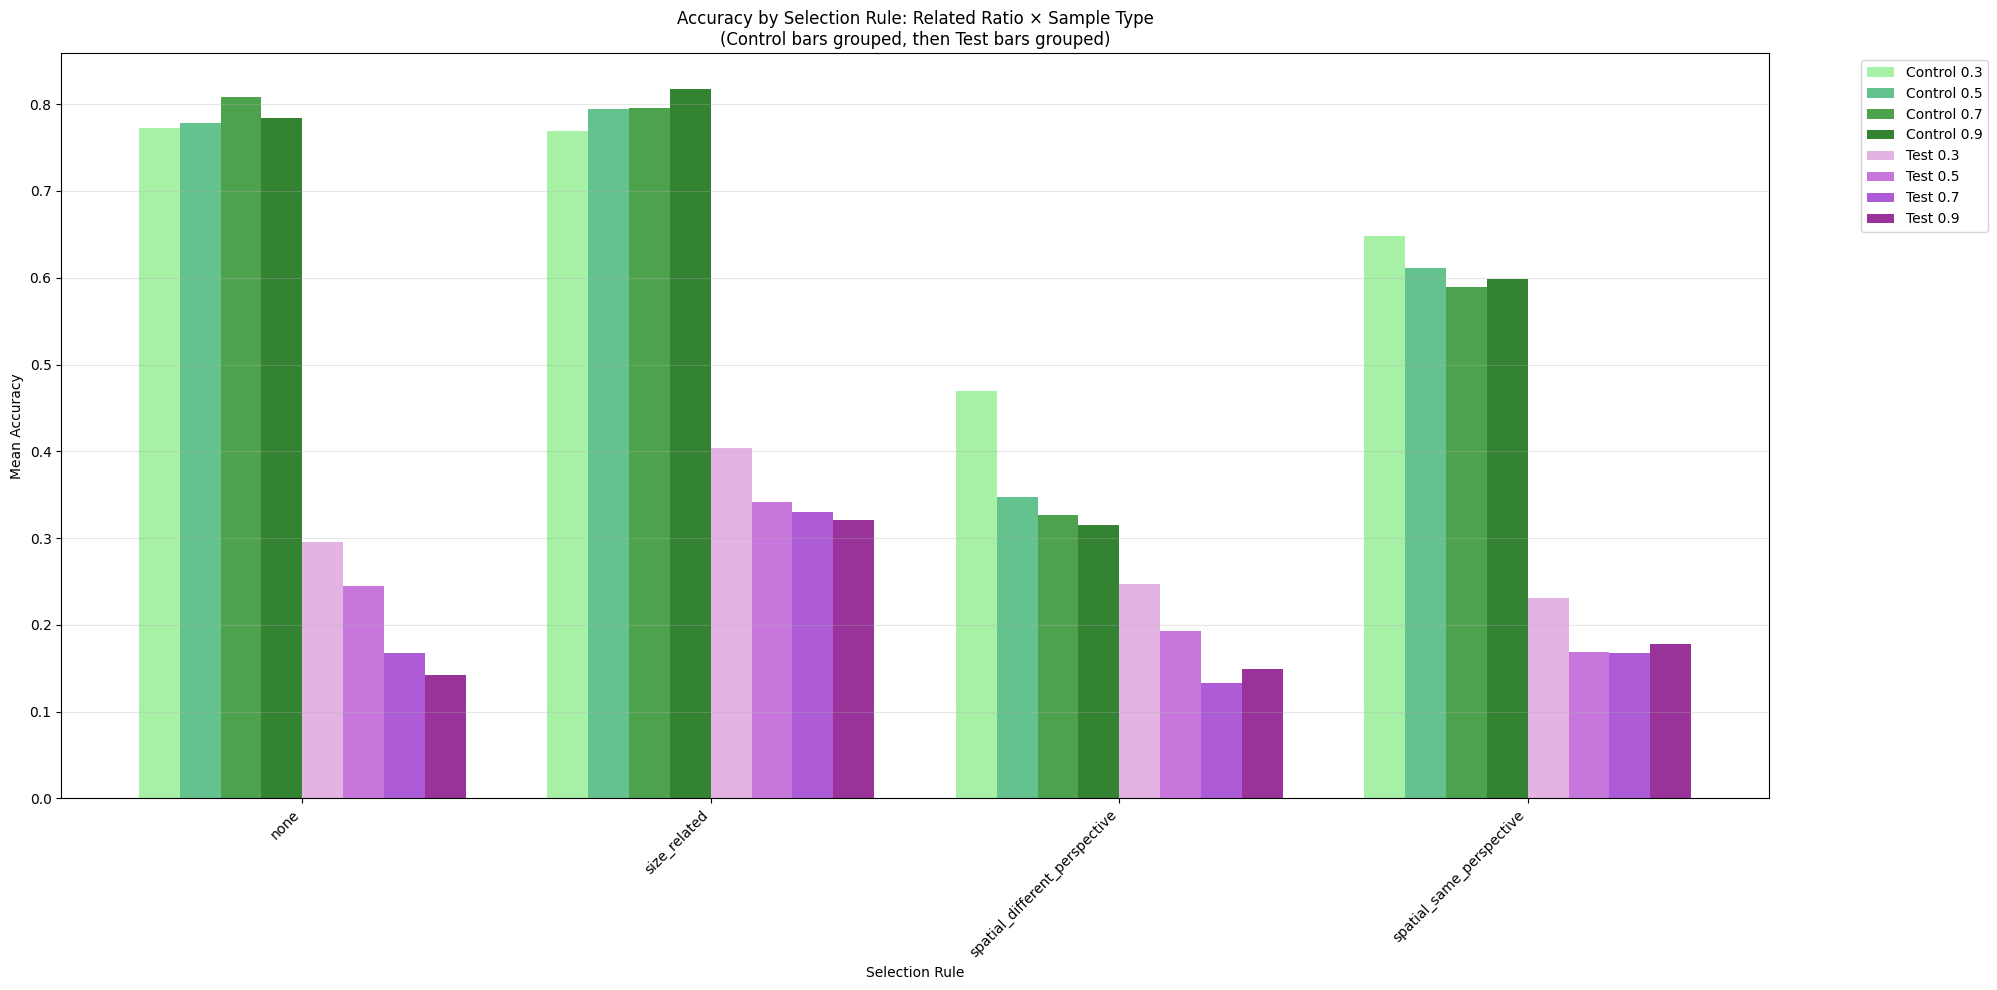


Summary by Selection Rule, Related Ratio, and Sample Type:

none:
  Control 0.3: mean=0.773, std=0.023, n=4
  Control 0.5: mean=0.778, std=0.037, n=4
  Control 0.7: mean=0.808, std=0.050, n=4
  Control 0.9: mean=0.784, std=0.062, n=4
  Test 0.3: mean=0.296, std=0.054, n=4
  Test 0.5: mean=0.245, std=0.080, n=4
  Test 0.7: mean=0.167, std=0.047, n=4
  Test 0.9: mean=0.142, std=0.043, n=4

size_related:
  Control 0.3: mean=0.769, std=0.020, n=4
  Control 0.5: mean=0.794, std=0.019, n=4
  Control 0.7: mean=0.796, std=0.035, n=4
  Control 0.9: mean=0.818, std=0.021, n=4
  Test 0.3: mean=0.404, std=0.008, n=4
  Test 0.5: mean=0.341, std=0.035, n=4
  Test 0.7: mean=0.330, std=0.042, n=4
  Test 0.9: mean=0.321, std=0.046, n=4

spatial_different_perspective:
  Control 0.3: mean=0.470, std=0.183, n=4
  Control 0.5: mean=0.347, std=0.085, n=4
  Control 0.7: mean=0.327, std=0.056, n=4
  Control 0.9: mean=0.315, std=0.064, n=4
  Test 0.3: mean=0.247, std=0.044, n=4
  Test 0.5: mean=0.193, std=0.0

In [25]:
# Calculate accuracy by selection_rule split by related_ratio AND sample_type
from collections import defaultdict

# Structure: {selection_rule: {'control_related_0.3': [accuracies], 'test_related_0.3': [accuracies], etc}}
related_sample_accuracy = defaultdict(lambda: {
    'control_related_0.3': [], 'test_related_0.3': [],
    'control_related_0.5': [], 'test_related_0.5': [],
    'control_related_0.7': [], 'test_related_0.7': [],
    'control_related_0.9': [], 'test_related_0.9': []
})

all_selection_rules = ["none", "size_related", "spatial_same_perspective", "spatial_different_perspective"]

# Calculate accuracies by selection_rule, related_ratio, and sample_type
for (fill_index, fill) in enumerate(fill_ratios):
    for (related_index, related) in enumerate(related_ratios):
        log = logs[fill_index][related_index]
        print(f"processing log: {log.location} (related_ratio={related})")
        temp_log = read_eval_log(log.location, resolve_attachments=False)
        
        # Track counts for each combination
        rule_counts = defaultdict(lambda: {
            'control': {'correct': 0, 'total': 0},
            'test': {'correct': 0, 'total': 0}
        })
        
        assert temp_log.samples is not None
        for sample in temp_log.samples:
            if ("selection_rule_type" in sample.metadata and 
                "sample_type" in sample.metadata):
                
                rule = sample.metadata["selection_rule_type"]
                sample_type = sample.metadata["sample_type"]
                
                # Count total and correct for this rule and sample type
                rule_counts[rule][sample_type]['total'] += 1
                if sample.score.value == "C":
                    rule_counts[rule][sample_type]['correct'] += 1
        
        # Calculate accuracies for each rule/sample_type combination at this related_ratio
        for rule in rule_counts:
            for sample_type in ['control', 'test']:
                category_key = f"{sample_type}_related_{related}"
                if rule_counts[rule][sample_type]['total'] > 0:
                    accuracy = rule_counts[rule][sample_type]['correct'] / rule_counts[rule][sample_type]['total']
                    related_sample_accuracy[rule][category_key].append(accuracy)
                else:
                    related_sample_accuracy[rule][category_key].append(None)
        
        del temp_log
        gc.collect()

# Create 8-bar grouped chart - control bars first, then test bars
plt.figure(figsize=(20, 10))

rules = sorted(related_sample_accuracy.keys())

# Reorganize: all control bars together, then all test bars together
categories = [
    'control_related_0.3', 'control_related_0.5', 'control_related_0.7', 'control_related_0.9',
    'test_related_0.3', 'test_related_0.5', 'test_related_0.7', 'test_related_0.9'
]

# Colors: 4 shades for control (greens), 4 shades for test (purples)
colors = [
    'lightgreen', 'mediumseagreen', 'forestgreen', 'darkgreen',     # Control bars
    'plum', 'mediumorchid', 'darkorchid', 'purple'                 # Test bars
]

labels = [
    'Control 0.3', 'Control 0.5', 'Control 0.7', 'Control 0.9',
    'Test 0.3', 'Test 0.5', 'Test 0.7', 'Test 0.9'
]

# Calculate means for each category
means_by_category = {cat: [] for cat in categories}
for rule in rules:
    for cat in categories:
        values = [acc for acc in related_sample_accuracy[rule][cat] if acc is not None]
        means_by_category[cat].append(np.mean(values) if values else 0)

# Create grouped bars
x = np.arange(len(rules))
width = 0.1

for i, (cat, color, label) in enumerate(zip(categories, colors, labels)):
    plt.bar(x + i * width - 3.5*width, means_by_category[cat], width, 
           label=label, color=color, alpha=0.8)

plt.xlabel('Selection Rule')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Selection Rule: Related Ratio × Sample Type\n(Control bars grouped, then Test bars grouped)')
plt.xticks(x, rules, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print summary
print("\nSummary by Selection Rule, Related Ratio, and Sample Type:")
for rule in sorted(related_sample_accuracy.keys()):
    print(f"\n{rule}:")
    for cat, label in zip(categories, labels):
        values = [acc for acc in related_sample_accuracy[rule][cat] if acc is not None]
        if values:
            print(f"  {label}: mean={np.mean(values):.3f}, std={np.std(values):.3f}, n={len(values)}")
        else:
            print(f"  {label}: no data")